# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pymorphy2

In [3]:
df = pd.read_excel('geo.xlsx').drop('Unnamed: 0', axis=1) #удалим нумерацию строк Unnamed

In [4]:
df.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [2]:
df_comment = pd.read_excel('geo_comment.xlsx').drop('Unnamed: 0', axis=1) #удалим нумерацию строк Unnamed

In [3]:
df_comment.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


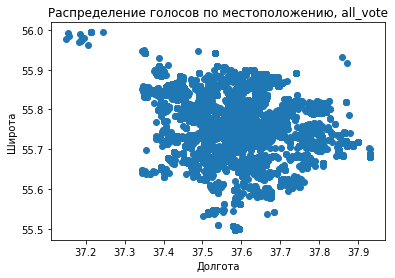

In [6]:
#Посмотрим как распределены голоса:
metric = ['all_vote', 'positive vote', 'negative vote']
fig, ax = plt.subplots()
ax.set_title(f'Распределение голосов по местоположению, {metric[0]}')
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
ax.scatter(df['x'], df['y'])

In [7]:
# Сделаем стандартизацию x и y:
    
def st_sc(data):
    """
    Стандартизуем данные геокоординат
    """
    st = StandardScaler()
    return st.fit_transform(data)

X_sc_all = st_sc(df[['x','y']])

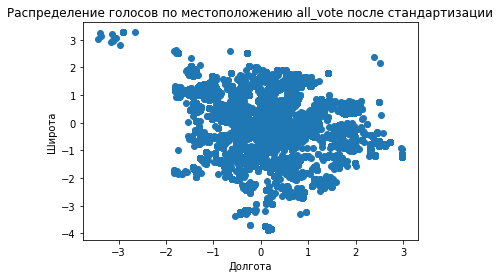

In [8]:
#Посмотрим на масштабы и распределение после стандартизации данных:
def get_allocation(X_sc, metric):
    fig, ax = plt.subplots()
    ax.set_title(f'Распределение голосов по местоположению {metric} после стандартизации')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    ax.scatter(X_sc[:,0], X_sc[:,1])

allocation_all = get_allocation(X_sc_all, metric[0])
allocation_all

In [9]:
# Характер распределения не изменился.

In [10]:
# Найдем оптимальное кол-во голосов
def clasters_count_inertia(X_sc, metric):
    """
    Выводим зависимость инерции от кол-ва кластеров
    """
    k_inertia = []
    ks = range(1,11)
    for k in ks:
        clf_kmeans = KMeans(n_clusters = k)
        clusters_kmeans = clf_kmeans.fit_predict(X_sc, )
        k_inertia.append(clf_kmeans.inertia_)
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    fig, ax = plt.subplots()
    ax.plot(ks[1:-1], diff_r)
    ax.set_title(f'Показатель Inertia для KMeans, {metric}')
    ax.set_xlabel('Кол-во кластеров')
    ax.set_ylabel('Инерция')

def best_clasters_count(X_sc):
    """
    Найдем оптимальное число кластеров
    """
    k_inertia = []
    ks = range(1,11)
    for k in ks:
        clf_kmeans = KMeans(n_clusters = k)
        clusters_kmeans = clf_kmeans.fit_predict(X_sc, )
        k_inertia.append(clf_kmeans.inertia_)
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    k_opt = ks[np.argmin(diff_r) + 1]
    return k_opt

Оптимальное количество кластеров all_vote:


8

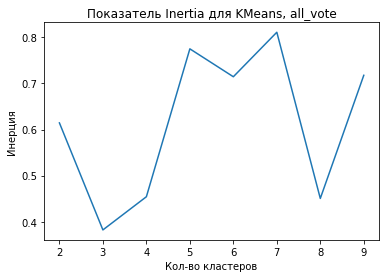

In [11]:
inertia_all_votes = clasters_count_inertia(X_sc_all, metric[0])
inertia_all_votes
print(f'Оптимальное количество кластеров {metric[0]}:')
best_clasters_count(X_sc_all)

In [12]:
def get_chart_clusters(X_sc, metric):
    """
    Выведем распределение голосов по кластерам 
    """
    n = best_clasters_count(X_sc)
    fig, ax = plt.subplots()
    clf_kmeans = KMeans(n_clusters = n)
    clusters = clf_kmeans.fit_predict(X_sc)
    ax.scatter(X_sc[:, 0], X_sc[:, 1], c = clusters, cmap = 'autumn', s = 60)
    ax.set_title(f'Кластеризация методом KMeans c оптимальным количеством кластеров: {n}, {metric}')
    
    centers = clf_kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s=50);

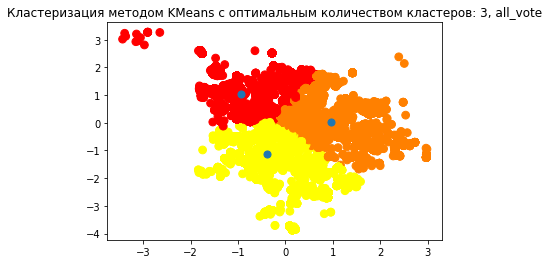

In [13]:
#Кластеризуем голоса с оптимальным кол-вом кластеров и визуализируем данные
all_votes_clusters = get_chart_clusters(X_sc_all, metric[0])
all_votes_clusters

In [14]:
# Голоса ЗА
X = df[df['comment_class'] == 1][['x','y']]

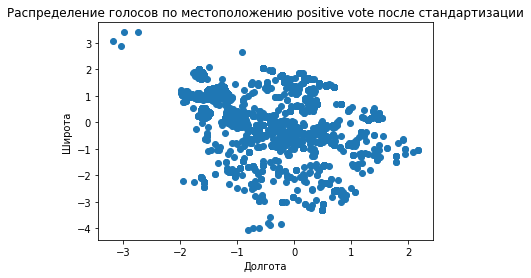

In [15]:
X_sc_pos = st_sc(X[['x','y']]) #стандартизируем данные 
#Посмотрим на масштабы и распределение после стандартизации данных:
allocation_pos = get_allocation(X_sc_pos, metric[1])
allocation_pos

Оптимальное количество кластеров positive vote:


3

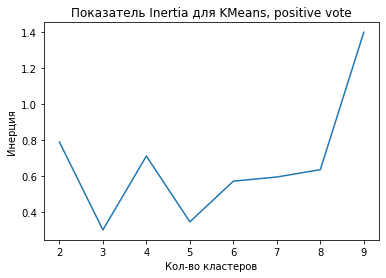

In [16]:
# Найдем оптимальное кол-во голосов
inertia_pos_votes = clasters_count_inertia(X_sc_pos, metric[1])
inertia_pos_votes
print(f'Оптимальное количество кластеров {metric[1]}:')
best_clasters_count(X_sc_pos)

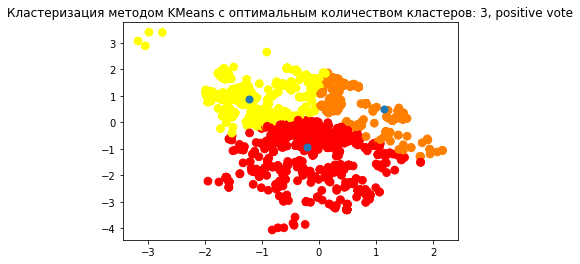

In [17]:
#Кластеризуем голоса с оптимальным кол-вом кластеров и визуализируем данные
pos_votes_clusters = get_chart_clusters(X_sc_pos, metric[1])
pos_votes_clusters

In [18]:
# Голоса ПРОТИВ
X = df[df['comment_class'] == -1][['x','y']]

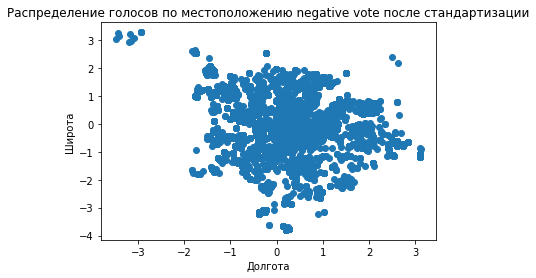

In [19]:
X_sc_neg = st_sc(X[['x','y']]) #стандартизируем данные 
#Посмотрим на масштабы и распределение после стандартизации данных:
allocation_neg = get_allocation(X_sc_neg, metric[2])
allocation_neg

Оптимальное количество кластеров negative vote:


3

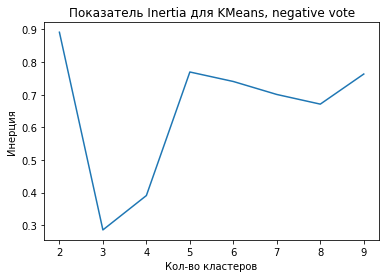

In [20]:
# Найдем оптимальное кол-во голосов
inertia_neg_votes = clasters_count_inertia(X_sc_neg, metric[2])
inertia_neg_votes
print(f'Оптимальное количество кластеров {metric[2]}:')
best_clasters_count(X_sc_neg)

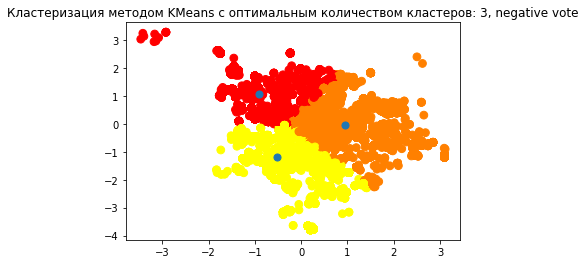

In [21]:
#Кластеризуем голоса с оптимальным кол-вом кластеров и визуализируем данные
neg_votes_clusters = get_chart_clusters(X_sc_neg, metric[2])
neg_votes_clusters

In [22]:
X_ = [X_sc_all, X_sc_pos, X_sc_neg]

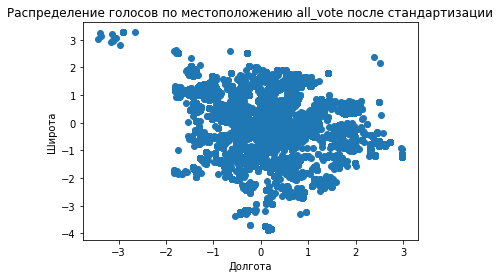

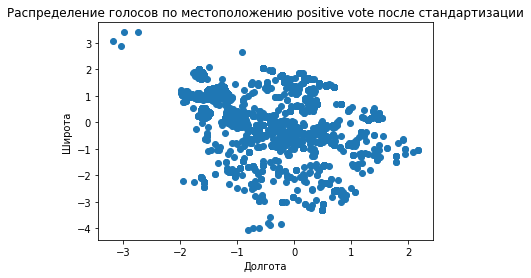

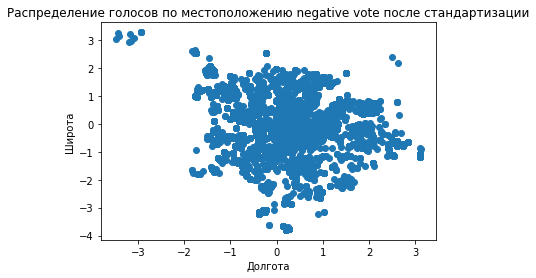

In [23]:
#Сравним распределения голосов:
for m, X_massive in zip(metric, X_):
    get_allocation(X_massive, m)
    plt.show()

In [24]:
# плотность распеределения голосов за значительно ниже плотности распределения голосов против, тенденции для всего распределения (all_vote)
# в первую очередь будут определяться негативными голосами

<Figure size 432x288 with 0 Axes>

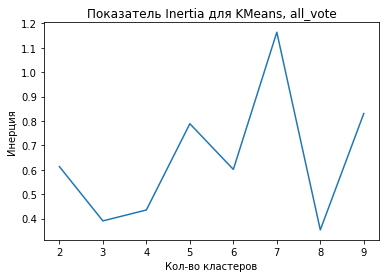

<Figure size 432x288 with 0 Axes>

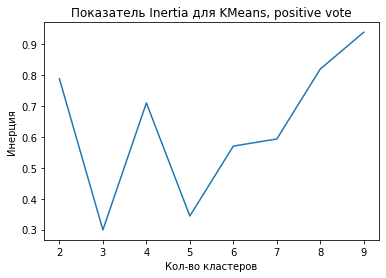

<Figure size 432x288 with 0 Axes>

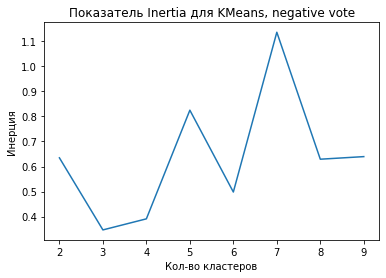

In [25]:
#Сравним оптимальное кол-во голосов:
for m, X_massive in zip(metric, X_):
    plt.figure()
    clasters_count_inertia(X_massive, m)
    plt.show()

<Figure size 432x288 with 0 Axes>

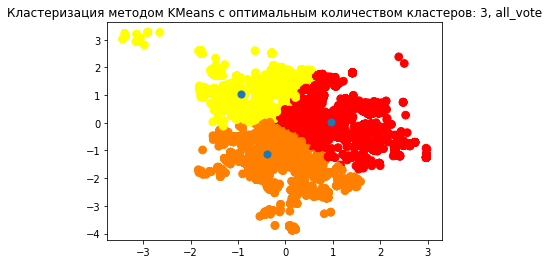

<Figure size 432x288 with 0 Axes>

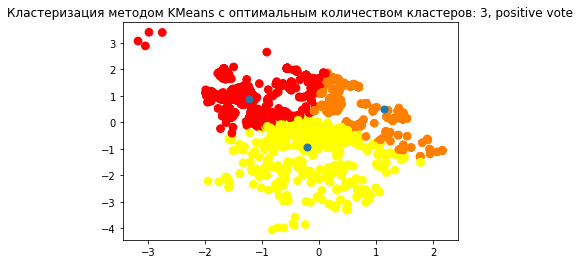

<Figure size 432x288 with 0 Axes>

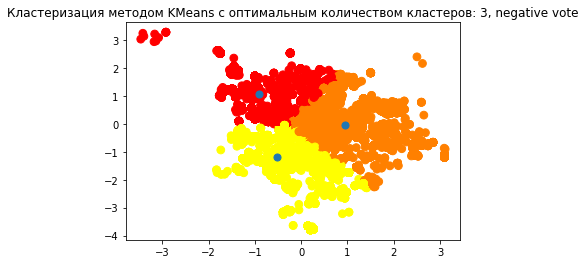

In [26]:
#Сравним результаты кластеризации:
for m, X_massive in zip(metric, X_):
    plt.figure()
    get_chart_clusters(X_massive, m)
    plt.show()

In [27]:
#Характер кластеров немного различается для голосов за (кластер снизу более обьемный, а верхний правый - более узкий)
#Характер кластеров для негативной оценки похож на распределение кластеров для всей выборки (определяется им?)

In [28]:
# Найдем наиболее активные в голосовании районы ()
def get_vote_regions(X_sc, metric):
    fig, ax = plt.subplots()
    cluster_dbsc = DBSCAN(eps=0.1)
    clusters = cluster_dbsc.fit_predict(X_sc)
    ax.scatter(X_sc[:, 0], X_sc[:, 1], c=clusters, cmap='gray', s=60)
    ax.set_title(f'Активность районов в голосовании {metric}')

<Figure size 432x288 with 0 Axes>

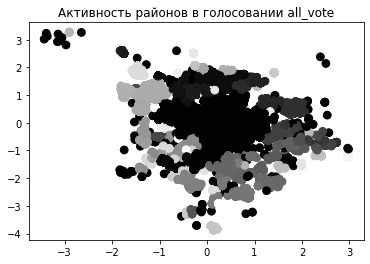

<Figure size 432x288 with 0 Axes>

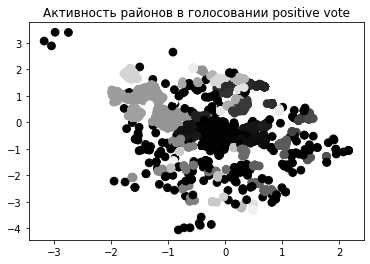

<Figure size 432x288 with 0 Axes>

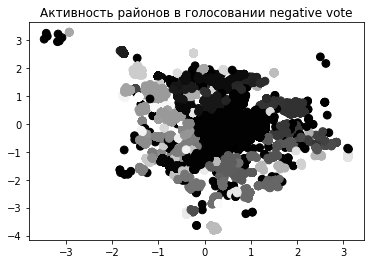

In [29]:
for m, X_massive in zip(metric, X_):
    plt.figure()
    get_vote_regions(X_massive, m)
    plt.show()

In [41]:
# из графиков видим, что в целом наибольшая активность голосов в центре, при этом данная тенденция больше определяется голосами против
# т.к. характер распределения в целом совпадает с характером распределения при голосовании против,
# а голосование за более-менее равномерно

In [4]:
# выделить основные тематики комментариев жителей
data_comments = list(df_comment['comment'].head(30)) #делаю для первых 30 комментов

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vera_Romantsova\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vera_Romantsova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from nltk.tokenize import sent_tokenize #токенизация
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize #работа с токенами в предложениях

In [7]:
stop_words = stopwords.words('russian') #для русского языка

In [8]:
morph = pymorphy2.MorphAnalyzer()
data_comments_clear = []
data_comments_clear_unique = []
for str_ in data_comments:
    sentences = nltk.sent_tokenize(str_, language="russian")
    for s in sentences:
        sentence_ = re.sub(r"[^А-Яа-яёЁ ]","", s)
        tokens = nltk.word_tokenize(sentence_) 
        tokens = [i for i in tokens if (i not in stop_words)] 
        tokens = list(map(lambda x: morph.parse(x)[0].normal_form, tokens))
        for t in tokens:
            data_comments_clear.append(t) #Добавим все слова с повторами
            if t not in data_comments_clear_unique:
                data_comments_clear_unique.append(t) #добавим уникальные слова

In [9]:
data_comments_clear

['в',
 'раздел',
 'правило',
 'землепользование',
 'застройка',
 'гмосква',
 'текстовый',
 'часть',
 'играфический',
 'схема',
 'необходимо',
 'внести',
 'изменение',
 'земельный',
 'участок',
 'кадастровымномер',
 'адрес',
 'первый',
 'самотёчный',
 'пер',
 'вл',
 'б',
 'пззтерриториальный',
 'зона',
 'исключить',
 'земельный',
 'участок',
 'часть',
 'моейобщий',
 'долевой',
 'собственность',
 'земельный',
 'участок',
 'многоквартирный',
 'дом',
 'а',
 'мусамотёчный',
 'пер',
 'площадь',
 'квм',
 'точка',
 'скоордината',
 'ю',
 'на',
 'основаниивступить',
 'законный',
 'сила',
 'судебный',
 'решение',
 'дело',
 'а',
 'оничтожность',
 'заключить',
 'договор',
 'аренда',
 'земельный',
 'участок',
 'адреснымиориентир',
 'й',
 'самотёчный',
 'пер',
 'вл',
 'б',
 'кадастровый',
 'номер',
 'на',
 'основание',
 'вступить',
 'законный',
 'сила',
 'судебный',
 'решение',
 'дело',
 'аот',
 'ничтожность',
 'заключить',
 'договор',
 'аренда',
 'земельный',
 'участкас',
 'адресный',
 'ориентир',
 

In [10]:
#Выведем наиболее часто встречаемое слово
print(max(set(data_comments_clear), key=lambda x: data_comments_clear.count(x)))

участок


In [17]:
from collections import Counter
c = Counter(data_comments_clear)
c

Counter({'в': 7,
         'раздел': 1,
         'правило': 6,
         'землепользование': 6,
         'застройка': 20,
         'гмосква': 7,
         'текстовый': 1,
         'часть': 6,
         'играфический': 1,
         'схема': 1,
         'необходимо': 2,
         'внести': 4,
         'изменение': 5,
         'земельный': 17,
         'участок': 26,
         'кадастровымномер': 1,
         'адрес': 21,
         'первый': 1,
         'самотёчный': 3,
         'пер': 15,
         'вл': 8,
         'б': 3,
         'пззтерриториальный': 1,
         'зона': 15,
         'исключить': 3,
         'моейобщий': 1,
         'долевой': 1,
         'собственность': 1,
         'многоквартирный': 2,
         'дом': 13,
         'а': 3,
         'мусамотёчный': 1,
         'площадь': 21,
         'квм': 16,
         'точка': 2,
         'скоордината': 1,
         'ю': 1,
         'на': 5,
         'основаниивступить': 1,
         'законный': 2,
         'сила': 2,
         'судебный': 3,
 

In [11]:
import gensim
from gensim import corpora
from gensim.corpora import Dictionary

In [20]:
texts = [[text for text in doc.split()] for doc in data_comments]
texts

[['Во',
  'все',
  'разделы',
  'правил',
  'землепользования',
  'и',
  'застройки',
  'г.Москвы',
  '(текстовые',
  'части',
  'и',
  'графические',
  'схемы)',
  'необходимо',
  'внести',
  'изменения',
  'по',
  'земельному',
  'участку',
  'с',
  'кадастровым',
  'номером',
  '77:01:0004002:188',
  'с',
  'адресом',
  'первый',
  'Самотёчный',
  'пер.,',
  'вл.',
  '17Б',
  '(в',
  'ПЗЗ',
  'территориальная',
  'зона',
  '№2034561)',
  'и',
  'исключить',
  'из',
  'этого',
  'земельного',
  'участка',
  'часть',
  'моей',
  'общей',
  'долевой',
  'собственности',
  '-',
  'земельного',
  'участка',
  'многоквартирного',
  'дома',
  '17А',
  'по',
  '1-му',
  'Самотёчному',
  'пер.',
  'площадью',
  '650,5',
  'кв.м',
  'с',
  'точками',
  '1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-1',
  'с',
  'координатами:',
  '12316.39',
  'и',
  '6983.68;',
  '123224',
  '6988.91;',
  '12316,45',
  'и',
  '7009,60;',
  '12328.04',
  'и',
  '7013.46;12327.73',
  'и',
  '7014.41;',
  '12330.06',


In [24]:
dictionary = corpora.Dictionary(texts)
print(dictionary)
print(dictionary.token2id)

Dictionary(719 unique tokens: ['(в', '(текстовые', '-', '1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-1', '1-й']...)
{'(в': 0, '(текстовые': 1, '-': 2, '1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-1': 3, '1-й': 4, '1-му': 5, '11.06.2015': 6, '12297.24': 7, '12297ю96': 8, '12302.02': 9, '12303.22': 10, '12304.74': 11, '12311.23': 12, '12316,45': 13, '12316.39': 14, '123224': 15, '12328.04': 16, '12330.06': 17, '12330.37': 18, '12330.82': 19, '12335.17': 20, '17А': 21, '17Б': 22, '18.06.2007': 23, '650,5': 24, '6983.68.': 25, '6983.68;': 26, '6988.91;': 27, '7000.60;': 28, '7003.64;': 29, '7004.18;': 30, '7005.49;': 31, '7009,60;': 32, '7012.47;': 33, '7013.46;12327.73': 34, '7014.24;': 35, '7014.41;': 36, '7015.18;': 37, '7015.83;': 38, '7021.28;': 39, '7028.61;': 40, '77:01:0004002:188': 41, '77:01:0004002:188.': 42, 'А40-51937/2011': 43, 'Во': 44, 'На': 45, 'ПЗЗ': 46, 'Самотёчному': 47, 'Самотёчный': 48, 'адресными': 49, 'адресом': 50, 'аренды': 51, 'в': 52, 'вл.': 53, 'внести': 54, 'все': 55, '

In [26]:
#создание мешка слов
bow_corpus = [dictionary.doc2bow(doc) for doc in texts]
bow_corpus

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 3),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 19),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 2),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 2),
  (89, 1),
  (90, 1),
  (91, 3

In [27]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [28]:
#Выведем основные темы (8)
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.026*"на" + 0.021*"с" + 0.020*"ул." + 0.018*"и" + 0.017*"в" + 0.013*"объекта" + 0.013*"зону" + 0.010*"участок" + 0.010*"до" + 0.010*"для"


Topic: 1 
Words: 0.024*"по" + 0.021*"с" + 0.020*"застройкой" + 0.015*"адресу" + 0.010*"пер." + 0.010*"что" + 0.010*"Левшинский" + 0.010*"согласна" + 0.010*"ознакомлена." + 0.010*"стр.3"


Topic: 2 
Words: 0.050*"и" + 0.026*"по" + 0.020*"с" + 0.019*"в" + 0.011*"участка" + 0.011*"земельного" + 0.010*"для" + 0.009*"от" + 0.008*"На" + 0.008*"пер.,"


Topic: 3 
Words: 0.052*"до" + 0.039*"площадью" + 0.025*"кв.м" + 0.024*"и" + 0.021*"м," + 0.019*"комплекса" + 0.019*"с" + 0.018*"строительства" + 0.015*"жилого" + 0.014*"общей"


Topic: 4 
Words: 0.022*"По" + 0.017*"№" + 0.017*"по" + 0.017*"с" + 0.017*"д." + 0.017*"адресу" + 0.017*"объекта" + 0.017*"Жители" + 0.017*"домов" + 0.017*"21016402."


Topic: 5 
Words: 0.035*"-" + 0.020*"с" + 0.020*"пер." + 0.016*"в" + 0.012*"по" + 0.008*"не" + 0.008*"участка" + 0.008*"земельного" + 0.008*"на" + 0